In [ ]:
!pwd
!ls

/content
drive  sample_data


In [ ]:
cd ./drive/My Drive/

/content/drive/My Drive


wrong line at:
,drop this line
wrong line at:
,drop this line
wrong line at:
,drop this line
wrong line at:
,drop this line
wrong line at:
,drop this line


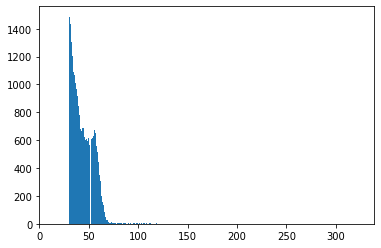

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


textCNN(
  (embeding): Embedding(58463, 50)
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=100, bias=True)
  (out): Linear(in_feat

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import gensim
#import gensim.models.word2vec as w2v
from sklearn.model_selection import train_test_split
import sklearn.metrics
import time


#数据预处理函数，返回文本与标签
def get_data(path):
#返回为文本，文本对应标签，文本数量
    data = []
    label = []
    nums = 0
    with open(path, 'r', encoding='UTF-8') as f:
        lines = f.readlines()
        text = ''
        for line in lines:
            try:
                label.append(torch.tensor(int(line[0]), dtype=torch.int64))
            except BaseException:  # 遇到首个字符不是标签的就跳过比如空行，并打印
                print('wrong line at:' + str(line) +  ",drop this line")
                continue
            line_words = line.strip().split()[1:-1]  # 按照空字符\t\n 空格来切分
            text = line_words
            # print(text)
            data.append(text)
            nums = nums + 1
    return data, label, nums
#load word 2 vetc，加载词向量，可以事先预训练
def getw2v():
    model_file_name = 'wiki_word2vec_50.bin'
    # 模型训练，生成词向量
    '''
    sentences = w2v.LineSentence('trainword.txt')
    model = w2v.Word2Vec(sentences, size=20, window=5, min_count=5, workers=4)
    model.save(model_file_name)
    '''
    # model = w2v.Word2Vec.load(model_file_name)
    model = gensim.models.KeyedVectors.load_word2vec_format(model_file_name, binary=True)
    return model;

train_texts,train_labels,train_nums=get_data('./train.txt') #texts[0:train_nums]
valid_texts,valid_labels,valid_nums=get_data('./validation.txt') #texts[train_nums:train_nums+valid_nums]
test_texts,test_labels,test_nums=get_data('./test.txt')#texts[train_nums+valid_nums:train_nums+valid_nums+test_nums]
texts = train_texts + valid_texts + test_texts
labels = train_labels + valid_labels + test_labels

sentence_length = [len(x) for x in texts] #长度
%matplotlib inline
#notebook
import matplotlib.pyplot as plt
plt.hist(sentence_length,max(sentence_length))
plt.xlim(0,max(sentence_length)/2)
plt.show()
#句子长度设为100就足够了

# time.sleep(100)
# print(texts[1])
# print(texts[-1])
# time.sleep(1000)
#textCNN模型
class textCNN(nn.Module):
    def __init__(self,args):
        super(textCNN, self).__init__()
        vocb_size = args['vocb_size']
        dim = args['dim']
        n_class = args['n_class']
        max_len = args['max_len']
        embedding_matrix=args['embedding_matrix']
        #需要将事先训练好的词向量载入
        self.embeding = nn.Embedding(vocb_size, dim,_weight=embedding_matrix)
        self.conv1 = nn.Sequential(
                     nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5,
                               stride=1, padding=2),

                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2) # (16,64,64)
                     )
        self.conv2 = nn.Sequential(
                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
                     nn.ReLU(),
                     nn.MaxPool2d(2)
                     )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(  # (16,64,64)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, 100)
        self.out = nn.Linear(100, n_class)

    def forward(self, x):
        x = self.embeding(x)
        x=x.view(x.size(0),1,max_len,word_dim)
        #print(x.size())
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1) # 将（batch，outchanel,w,h）展平为（batch，outchanel*w*h）
        # print(x.size())
        output = self.fc1(x)
        output = self.fc2(output)
        output = self.out(output)
        return output

#此处统计了所有词的次数
word_vocb=[]
word_vocb.append('')
for text in texts:
    for word in text:
        word_vocb.append(word)
word_vocb=set(word_vocb)#使用set去重
vocb_size=len(word_vocb)#得到了出现的不同的词的个数 58463 个
# print(vocb_size) #58436
# time.sleep(1000)
#设置词表大小
nb_words=40000
if nb_words<vocb_size:
    nb_words=vocb_size
max_len=100;#限定的每个句子的长度，超过截取，小于补0
word_dim=50;#每个词vector的维度
n_class=2;#最后的分类


args={}
#textCNN调用的参数
args['vocb_size']=nb_words#词表大小
args['max_len']=max_len
args['n_class']=n_class
args['dim']=word_dim


#词表与索引的map
word_to_idx={word:i for i,word in enumerate(word_vocb)}
idx_to_word={word_to_idx[word]:word for word in word_to_idx}
#每个单词的对应的词向量
embeddings_index = getw2v()
#预先处理好的词向量
embedding_matrix = np.zeros((nb_words, word_dim))
for word, i in word_to_idx.items():
    if i >= nb_words:
        continue
    if word in embeddings_index:
        embedding_vector = embeddings_index[word]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
args['embedding_matrix']=torch.Tensor(embedding_matrix)

#生成训练数据，需要将训练数据的Word转换为word的索引
texts_with_id=np.zeros([len(texts),max_len]) # 训练句子总数 * 句子长度的矩阵
for i in range(0,len(texts)):#第i句影评
    if len(texts[i])<max_len:#句子长度比max_len小
        for j in range(0,len(texts[i])):#其中第j个词
            texts_with_id[i][j]=word_to_idx[texts[i][j]]
        for j in range(len(texts[i]),max_len):
            texts_with_id[i][j] = word_to_idx['']
    else:
        for j in range(0,max_len):
            texts_with_id[i][j]=word_to_idx[texts[i][j]]

#构建textCNN模型
cnn=textCNN(args)
print(cnn)

EPOCH=3
LR = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
#损失函数
loss_function = nn.CrossEntropyLoss()
#训练批次大小
batch_size=100;
#划分训练数据和测试数据
x_train, x_test, y_train, y_test = train_test_split(texts_with_id, labels, test_size=0.1, random_state = int(time.time()), shuffle = True)

test_x=torch.LongTensor(x_test)
test_y=torch.LongTensor(y_test)
train_x=x_train
train_y=y_train

test_batch_size=100;
#开始训练
for epoch in range(EPOCH):
    for i in range(0,(int)(len(train_x)/batch_size)):
        b_x = Variable(torch.LongTensor(train_x[i*batch_size:i*batch_size+batch_size]))
        b_y = Variable(torch.LongTensor((train_y[i*batch_size:i*batch_size+batch_size])))
        output = cnn(b_x)
        loss = loss_function(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        pred_y = torch.max(output, 1)[1].data.squeeze()
        # print(sklearn.metrics.accuracy_score(b_y.numpy().tolist(),pred_y.numpy().tolist()))
        acc = (b_y == pred_y)
        accuracy = acc.numpy().sum() / b_y.size(0)
        if(i+1)%10 == 0:
          print('TRAIN:EPOCH [%d/%d],batch[%d/%d],train loss is: %s, now accuracy is: %s\n'%(epoch+1,EPOCH,i+1,len(train_x)/batch_size,str(loss.item()),str(accuracy)))
    
    # 测试
    test_all = 0
    test_right = 0
    pred = []
    target = []
    for j in range(0, (int)(len(test_x) / test_batch_size)):
        b_x = Variable(torch.LongTensor(test_x[j * test_batch_size:j * test_batch_size + test_batch_size]))
        b_y = Variable(torch.LongTensor((test_y[j * test_batch_size:j * test_batch_size + test_batch_size])))
        test_output = cnn(b_x)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        pred += pred_y.numpy().tolist()
        target += b_y.numpy().tolist()
        acc = (pred_y == b_y)
        acc = acc.numpy().sum()
        now_acc = acc / b_y.size(0)
        test_right = test_right + acc
        test_all = test_all + b_y.size(0)
        total_acc = test_right / test_all
        print('TEST:in batch[%d/%d] accuracy is: %s, total accuracy is: %s\n'%(j+1,len(test_x)/test_batch_size,str(now_acc),str(total_acc)))
        print("sklearn: now accuracy_score is %s,  precision_score is %s, recall_score is %s, f1-score is %s"
        %(sklearn.metrics.accuracy_score(target,pred),sklearn.metrics.precision_score(target,pred,average='binary'),
          sklearn.metrics.recall_score(target,pred,average='binary'),sklearn.metrics.f1_score(target,pred,average='binary')  ))
        print("sklearn:confusion_matrix is ")
        print(sklearn.metrics.confusion_matrix(target,pred))
      
